# DACON - 제주시 퇴근시간 버스승차인원 예측 대회
### 제주도 버스의 효율적인 운행을 위한 퇴근시간 승차인원을 예측하는 모델

### 패키지

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from selenium import webdriver
from haversine import haversine

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# 01. 외부 데이터 수집
### 01-01. 관광
### 제주공항 일일예상승객정보 수집 크롤러를 이용하여 `airport` 데이터프레임에 저장
- 한국공항공사 홈페이지에서 제주공항 일일 예상 승객 정보를 가져와 **`airport`** 데이터프레임에 저장
- 기간: 2019-08-01 ~ 2019-10-31
- 출처: https://www.airport.co.kr/www/extra/dailyExpect/dailyExpectList/layOut.do?yyyy=2019&mm=9&dd=1

In [2]:
driver = webdriver.Chrome("./chromedriver")
airport = pd.DataFrame(columns=["date", "korean", "foreigner"])
for m in [8, 9, 10]:
    for d in range(1, 32):
        date = "2019-" + str(m) + "-" + str(d)
        url = "https://www.airport.co.kr/www/extra/dailyExpect/dailyExpectList/layOut.do?yyyy=2019&mm=" + str(m) + "&dd=" +str(d)
        try:
            driver.get(url)
            driver.implicitly_wait(2)
            korean    = driver.find_element_by_xpath('//*[@id="customer_container"]/div[6]/div/table/tfoot/tr/td[5]').text
            foreigner = driver.find_element_by_xpath('//*[@id="customer_container"]/div[6]/div/table/tfoot/tr/td[6]').text
            
            if (korean=="0") or (foreigner=="0"):
                continue
            
            driver.implicitly_wait(2)
            airport = airport.append({"date":date, "korean":korean, "foreigner":foreigner}, ignore_index=True)
            driver.implicitly_wait(2)
        except:
            pass
        
driver.close()

- 변수형 변환

In [3]:
airport["date"] = pd.to_datetime(airport["date"])
airport["korean"] = airport["korean"].str.replace(",", "").astype(int)
airport["foreigner"] = airport["foreigner"].str.replace(",", "").astype(int)

- **`visitor`** 변수에 내국인과 외국인 이용객 수를 합한 값을 저장

In [4]:
airport["visitor"] = airport["korean"] + airport["foreigner"]

- 해당 날짜의 3일전, 2일전, 1일전 총 방문객 수 정보를 가지고 있는 **`(t-3), (t-2), (t-1)`** 변수 추가
- **`2019-09-01~2019-10-16`** 기간의 데이터만 저장

In [5]:
def get_previous_data(df):
    df["(t-3)"], df["(t-2)"], df["(t-1)"] = None, None, None
    for i in range(3, len(df)):
        df["(t-3)"][i] = int(df["visitor"][i-3])
        df["(t-2)"][i] = int(df["visitor"][i-2])
        df["(t-1)"][i] = int(df["visitor"][i-1])
    df.dropna(inplace=True)
    df = df.loc[31:76].reset_index(drop=True)
    return df
airport = get_previous_data(airport)

C:\Users\kimminsu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\kimminsu\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\kimminsu\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


- 최근 3일간 제주공항 총 이용객 수를 **`visitor_3days`** 변수에 저장

In [6]:
airport["visitor_3days"] = airport["(t-1)"] + airport["(t-2)"] + airport["(t-3)"]

### 제주지역 주요관광지점 입장객 통계(2015년~2019년)
- 관광지식정보시스템에서 제주지역 주요관광지점 입장객 5개년 통계 데이터를 저장
- 출처: https://know.tour.go.kr/stat/tourStatSearchDis.do;jsessionid=DC7A844358F8D44AD08FE9F17BA70A1B

In [9]:
attraction = pd.read_excel("./data/제주 주요관광지점 입장객 통계.xls")

- 관광지 별로 5개년 총계만 저장하는 데이터프레임 생성

In [11]:
spot = pd.DataFrame({"name":[], "entrant":[]})
for i in range(0, len(attraction)):
    if attraction["내/외국인"][i] == "합계":
        spot = spot.append({"name":attraction["관광지"][i], "entrant":attraction["총계"][i].replace(",", "")}, ignore_index=True)

- 관광지명이 중복되는 값들이 존재하여 하나의 값으로 합친 후 중복 제거

In [12]:
spot.loc[spot["name"]=="항몽 유적지", "entrant"] = 191830 + 227119
spot.loc[spot["name"]=="제주항일기념관", "entrant"] = 401717 + 292502
spot.loc[spot["name"]=="제주추사관", "entrant"] = 191211 + 206162
spot = spot.drop_duplicates().reset_index(drop=True)

- 구글 지도 검색을 통해 각 관광지의 위도/경도 정보를 가져와 **`spot_geocode`** 딕셔너리에 저장

In [13]:
spot_geocode = {"도립미술관": (33.452489, 126.489892), "만장굴관광지": (33.528593, 126.771470), "민속자연사박물관": (33.506724, 126.531586), "비자림": (33.484478, 126.806447),
               "삼양선사유적지": (33.523114, 126.587842), "절물자연휴양림": (33.439650, 126.629434), "제주도립 김창열미술관": (33.339047, 126.268235), "제주돌문화공원": (33.448834, 126.658701),
               "제주목관아지": (33.513623, 126.521968), "제주별빛누리공원": (33.444682, 126.549200), "제주항일기념관": (33.541782, 126.642933), "항몽 유적지": (33.452224, 126.407726),
               "해녀 박물관": (33.523775, 126.863540), "국립제주박물관": (33.513536, 126.548980), "삼양선사유적지": (33.523186, 126.587789), "한라산국립공원": (33.375321, 126.533089),
               "감귤박물관": (33.271676, 126.607607), "기당미술관": (33.244848, 126.551252), "마라해양도립공원": (33.118159, 126.267831), "박물관은살아있다": (33.255073, 126.408636),
               "산방산": (33.244078, 126.312759), "서귀포도립해양공원": (33.246939, 126.557900), "서귀포자연휴양림": (33.311528, 126.460233), "서복전시관": (33.245038, 126.570858),
               "성산일출봉": (33.462633, 126.942843), "이중섭미술관": (33.246065, 126.564983), "일출랜드": (33.383712, 126.841353), "정방폭포": (33.245058, 126.571868),
               "제주추사관": (33.250097, 126.278324), "중문대포해안주상절리대": (33.238108, 126.424584), "천제연폭포": (33.250847, 126.416762), "천지연폭포": (33.249523, 126.554416),
               "카멜리아힐": (33.289209, 126.370117), "퍼시픽랜드": (33.243925, 126.415752), "한화아쿠아플라넷제주": (33.433026, 126.927899)}

- **`spot`** 데이터프레임에 **`latitude(위도), longitude(경도)`** 변수 추가

In [14]:
spot["latitude"]  = spot["name"].apply(lambda x: spot_geocode[x][0])
spot["longitude"] = spot["name"].apply(lambda x: spot_geocode[x][1])

- **`entrant`** 변수의 값을 연평균 관광객으로 변환

In [15]:
spot["entrant"] = spot["entrant"].astype(int) / 5

#### **`grade`** 변수 생성
- **`entrant(연평균 관광객)`**이 50만명 이상일 경우 "A" 등급
- **`entrant(연평균 관광객)`**이 10만명 이상 50만명 미만일 경우 "B" 등급
- **`entrant(연평균 관광객)`**이 10만명 미만일 경우 "C" 등급

In [18]:
def grade(x):
    if x>=500000:
        return "A"
    elif (x>=100000) & (x<500000):
        return "B"
    else:
        return "C"
    
spot["grade"] = spot["entrant"].apply(grade)

### 01-02. 날씨
- 기상자료개방포털에서 제주지역 지상관측 자료 수집(2019-09-01 ~ 2019-10-16)
- 출처: https://data.kma.go.kr/data/grnd/selectAsosRltmList.do?pgmNo=36

In [20]:
weather = pd.read_csv("./data/제주도 지상관측 자료.csv", engine="python", parse_dates=["일시"])

- 결측치 다수 존재

In [21]:
weather.isnull().sum()

지점            0
지점명           0
일시            0
기온(°C)        0
강수량(mm)    3473
풍속(m/s)      46
습도(%)         0
dtype: int64

#### Data leakage 방지를 위해 06 ~ 12시 이외 데이터 제외
- **`일시`** 변수에서 시간을 추출하여 **`time`** 변수에 저장 후 시간 정보는 삭제

In [22]:
weather["time"] = weather["일시"].apply(lambda x: x.time().strftime("%H"))
weather["일시"] = weather["일시"].apply(lambda x: x.strftime("%Y-%m-%d"))

- 06 ~ 12시 이외 데이터 제외

In [23]:
weather = weather.loc[(weather["time"].astype(int) > 5) & (weather["time"].astype(int) < 13), :]
weather.reset_index(drop=True, inplace=True)

#### 변수명 변경

In [24]:
weather.columns = ["weather_stn_id", "weather_stn_name", "date", "temp", "rain", "wind", "humidity", "time"]

#### 보간(interpolation)
- 결측값들을 앞뒤 자료를 고려하여 채워넣음

In [25]:
weather.interpolate(limit_direction="both", inplace=True)

#### 최종 날씨 정보를 저장할 데이터프레임 생성

In [26]:
weather2 = weather[["weather_stn_id", "weather_stn_name", "date"]].drop_duplicates().reset_index(drop=True)
weather2.head()

,weather_stn_id,weather_stn_name,date
0,184,제주,2019-09-01
1,184,제주,2019-09-02
2,184,제주,2019-09-03
3,184,제주,2019-09-04
4,184,제주,2019-09-05


In [27]:
def get_variable(start, end, category):
    result = []
    
    for ID in [184, 185, 188, 189]:
        for d in np.unique(weather2.date):
            tmp = weather.loc[(weather.weather_stn_id==ID) & (weather.date==d)]
            start_value = float(tmp.loc[tmp.time==start, category])
            end_value = float(tmp.loc[tmp.time==end, category])
            result.append((start_value + end_value)/2)
    return result

In [28]:
start = ["06", "07", "08", "09", "10", "11"]
end = ["07", "08", "09", "10", "11", "12"]
category = ["temp", "rain", "wind", "humidity"]

for s, e in zip(start, end):
    for c in category:
        var_name = s + "~" + e + "_" + c
        weather2[var_name] = get_variable(s, e, c)

#### `THI(불쾌지수)`  변수 추가
- 불쾌지수 공식: **`(1.8 * 기온) - (0.55 * (1-습도(%)) * (1.8 * 기온 - 26)) + 32`** 

#### `THI_category` 변수 추가
- **`THI(불쾌지수)`** 80 이상: 매우 높음(3), 전원 불쾌감을 느낌
- **`THI(불쾌지수)`** 75 이상 80 미만: 높음(2), 50% 정도 불쾌감을 느낌
- **`THI(불쾌지수)`** 68 이상 75 미만: 보통(1), 불쾌감을 나타내기 시작함
- **`THI(불쾌지수)`** 68 미만: 낮음(0), 전원 쾌적함을 느낌

In [30]:
def THI(start, end):
    temp = start + "~" + end + "_temp"
    humidity = start + "~" + end + "_humidity"
    return (1.8 * weather2[temp]) - (0.55 * (1-weather2[humidity]*0.01) * (1.8 * weather2[temp] - 26)) + 32

def THI_category(x):
    if x >= 80:
        return 3
    elif (x >= 75) & (x < 80):
        return 2
    elif (x >= 68) & (x < 75):
        return 1
    else:
        return 0

In [31]:
weather2["06~07_THI"] = THI("06", "07")
weather2["07~08_THI"] = THI("07", "08")
weather2["08~09_THI"] = THI("08", "09")
weather2["09~10_THI"] = THI("09", "10")
weather2["10~11_THI"] = THI("10", "11")
weather2["11~12_THI"] = THI("11", "12")

In [32]:
weather2["06~07_THI_category"] = pd.Categorical(weather2["06~07_THI"].apply(THI_category))
weather2["07~08_THI_category"] = pd.Categorical(weather2["07~08_THI"].apply(THI_category))
weather2["08~09_THI_category"] = pd.Categorical(weather2["08~09_THI"].apply(THI_category))
weather2["09~10_THI_category"] = pd.Categorical(weather2["09~10_THI"].apply(THI_category))
weather2["10~11_THI_category"] = pd.Categorical(weather2["10~11_THI"].apply(THI_category))
weather2["11~12_THI_category"] = pd.Categorical(weather2["11~12_THI"].apply(THI_category))

#### `rain_category` 변수 추가
- **`rain(강수량)`**이 10.0보다 작으면 비가 오지 않음: 0
- **`rain(강수량)`**이 10.0보다 크면 비가 옴 : 1

In [33]:
def rain_category(x):
    if x <= 10:
        return 0
    else:
        return 1

In [34]:
weather2["06~07_rain_category"] = pd.Categorical(weather2["06~07_rain"].apply(rain_category))
weather2["07~08_rain_category"] = pd.Categorical(weather2["07~08_rain"].apply(rain_category))
weather2["08~09_rain_category"] = pd.Categorical(weather2["08~09_rain"].apply(rain_category))
weather2["09~10_rain_category"] = pd.Categorical(weather2["09~10_rain"].apply(rain_category))
weather2["10~11_rain_category"] = pd.Categorical(weather2["10~11_rain"].apply(rain_category))
weather2["11~12_rain_category"] = pd.Categorical(weather2["11~12_rain"].apply(rain_category))

#### 기상자료개발포털에서 관측 지점의 위도, 경도를 가져와 **`weather_geocode`** 딕셔너리에 저장
- 출처: https://data.kma.go.kr/tmeta/stn/selectStnList.do

In [35]:
weather_geocode = {"184": (33.5141, 126.5297), "185": (33.2938, 126.1628), "188": (33.3868, 126.8804), "189": (33.2462, 126.5653)}

- **`weather2`** 데이터프레임에 **`latitude, longitude`** 변수로 추가

In [36]:
weather2["weather_stn_latitude"] = weather2.weather_stn_id.apply(lambda x: weather_geocode[str(x)][0])
weather2["weather_stn_longitude"] = weather2.weather_stn_id.apply(lambda x: weather_geocode[str(x)][1])

#### 변수형 변환

In [37]:
weather2["weather_stn_id"] = pd.Categorical(weather2["weather_stn_id"].astype(str))
weather2["date"] = pd.to_datetime(weather2["date"], format="%Y-%m-%d")

# 02. 제공 데이터
### 02-01. 데이터 확인
#### 훈련 데이터 확인

In [38]:
trainval = pd.read_csv("./data/train.csv", parse_dates=["date"])
trainval.head(1)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,18~20_ride
0,0,2019-09-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,0.0,1.0,...,5.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
print("train 데이터의 구조:", trainval.shape)
print("train 결측값 개수:", trainval.isnull().sum().sum())

train 데이터의 구조: (415423, 21)
train 결측값 개수: 0


#### 테스트 데이터 확인

In [40]:
test = pd.read_csv("./data/test.csv", parse_dates=["date"])
test.head(1)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,4.0,4.0,7.0,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [41]:
print("test 데이터의 구조:", test.shape)
print("test 결측값 개수:", test.isnull().sum().sum())

test 데이터의 구조: (228170, 20)
test 결측값 개수: 0


### 02-02. Feature engineering - 날짜 관련
- **`date`** 변수를 통해 데이터의 요일을 추출하여 **`dayofweek`** 변수에 저장
    - 0: 월요일, 1: 화요일, 2: 수요일, 3: 목요일, 4: 금요일, 5: 토요일, 6: 일요일

In [42]:
trainval["dayofweek"] = trainval["date"].apply(lambda x: x.weekday())
test["dayofweek"] = test["date"].apply(lambda x: x.weekday())

In [43]:
test.head(1)

,id,date,bus_route_id,in_out,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,...,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,8~9_takeoff,9~10_takeoff,10~11_takeoff,11~12_takeoff,dayofweek
0,415423,2019-10-01,4270000,시외,344,제주썬호텔,33.4899,126.49373,4.0,4.0,...,2.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1


- 월 ~ 목의 퇴근시간 평균 승차 인원 수와 금 ~ 일의 퇴근시간 평균 승차 인원 수와의 유의미한 차이가 있다.

In [44]:
trainval.groupby(["dayofweek"])["18~20_ride"].mean()

dayofweek
0    1.343710
1    1.375319
2    1.430856
3    1.256710
4    1.067439
5    1.062123
6    1.034282
Name: 18~20_ride, dtype: float64

#### `weekday` 변수 생성
- **`weekday=0`**: 월/화/수/목
- **`weekday=1`**: 금/토/일/공휴일(추석, 개천절, 한글날 등)

In [45]:
def weekday_category(x):
    holiday = ["2019-09-12", "2019-09-13", "2019-09-14", "2019-09-15", "2019-10-03", "2019-10-09"]
    
    if (x in holiday) or x.weekday() > 3:
        return 1
    else:
        return 0
    
trainval["weekday"] = trainval.date.apply(weekday_category)

### 02-03. Feature engineering - 정류소 관련
- **`train과 test`**셋의 모든 정류소에 대한 정보를 **`stn`** 데이터프레임에 저장한다.

In [46]:
stn = trainval[["station_code", "station_name", "latitude", "longitude"]]
stn = stn.append(test[["station_code", "station_name", "latitude", "longitude"]])
stn = stn.drop_duplicates()
stn = stn.sort_values(by=["station_code"]).reset_index(drop=True)

- 각 정류소와 기상 관측소와의 거리를 측정하여 정류소와 가장 가까운 기상 관측소를 할당

In [47]:
def get_weather_stn(x):
    bus_stn_geocode = (x["latitude"], x["longitude"])
    weather_stn_list = list(weather_geocode.keys())
    weather_geocode_list = list(weather_geocode.values())
    
    distance = list()
    
    for g in weather_geocode_list:
        distance.append(haversine(bus_stn_geocode, g))
        
    return weather_stn_list[np.argmin(distance)]    

stn["weather_stn_id"] = stn.apply(get_weather_stn, axis=1)

- 위도, 경도 정보를 이용하여 각 정류소에서 반경 1km(도보 15분 거리) 안에 있는 관광지를 등급별로 카운트

In [48]:
def get_spot(x, grade):
    bus_stn_geocode = (x["latitude"], x["longitude"])
    count = 0
    
    for i in range(len(spot)):
        if spot["grade"][i] == grade:
            dist = haversine(bus_stn_geocode, (spot["latitude"][i], spot["longitude"][i]))
            if dist < 1:
                count += 1
    return count

In [49]:
stn["n_A_grade"] = stn.apply(get_spot, grade="A", axis=1)
stn["n_B_grade"] = stn.apply(get_spot, grade="B", axis=1)
stn["n_C_grade"] = stn.apply(get_spot, grade="C", axis=1)

- 각 정류소에서 유니크한 **`bus_route_id`**를 카운트하여 해당 정류소에서 이용할 수 있는 노선의 수를 **`n_route`**에 저장 후 **`stn`**과 병합

In [50]:
n_route = trainval[["station_code", "bus_route_id"]]
n_route = n_route.append(test[["station_code", "bus_route_id"]])
n_route.drop_duplicates(inplace=True)
n_route = n_route.groupby("station_code").count()
n_route = n_route.sort_values(by=["station_code"]).reset_index()
n_route.columns = ["station_code", "n_route"]
stn = stn.merge(n_route)

### 02-04. Feature engineering - 버스 노선 관련
- **`train과 test`**셋의 각 노선이 포함된 정류소의 정보를 **`route`** 데이터프레임에 저장한다.

In [51]:
route = trainval[["station_code", "bus_route_id"]]
route = route.append(test[["station_code", "bus_route_id"]])
route.drop_duplicates(inplace=True)
route = route.groupby("bus_route_id").count()
route = route.sort_values(by=["bus_route_id"]).reset_index()
route.columns = ["bus_route_id", "n_station"]

### 02-05. 최종 데이터셋 생성
#### 모델 훈련과 검증을 위해 제공된 **`train`** 데이터를 다시 **`train/val`** 데이터로 분리
- **`train`**: 2019-09-01 ~ 2019-09-21
- **`val`**: 2019-09-22 ~ 2019-09-30

In [53]:
train = trainval.loc[trainval.date.dt.day<22].reset_index(drop=True)
val = trainval.loc[trainval.date.dt.day>21].reset_index(drop=True)

print("train 데이터 구조: ", train.shape)
print("val   데이터 구조: ", val.shape)

train 데이터 구조:  (289010, 23)
val   데이터 구조:  (126413, 23)


- 각 노선 + 시내/시외 + 정류소 별로 요일별/시간별 평균 승하차 인원을 반환하는 사용자 정의 함수 **`get_average_passengers`** 정의

In [54]:
def get_average_passengers(df):
    result = df.drop(["id", "date", "station_name", "latitude", "longitude", 'weekday', "18~20_ride"], axis=1)
    result["bus"] = result.bus_route_id.astype(str) + " " + result.in_out.astype(str) + " " + result.station_code.astype(str) + " " + result.dayofweek.astype(str)
    result.drop(["bus_route_id", "in_out", "station_code", "dayofweek"], axis=1, inplace=True)
    result = result.groupby("bus").mean().reset_index()
 
    col_list = []
    
    for col_idx in range(1, len(result.columns)):
        col_list.append("mean_" + result.columns[col_idx])
        
    col_list = ["bus"] + col_list
    result.columns = col_list
    
    result["bus_route_id"] = result.bus.apply(lambda x: x.split(" ")[0]).astype(int)
    result["in_out"] =  result.bus.apply(lambda x: x.split(" ")[1])
    result["station_code"] =  result.bus.apply(lambda x: x.split(" ")[2]).astype(int)
    result["dayofweek"] = result.bus.apply(lambda x: x.split(" ")[3]).astype(int)
    result.drop(["bus"], axis=1, inplace=True)
    
    return result

train_passengers = get_average_passengers(train)

#### 제공 데이터와 추가로 생성한 데이터를 병합하여 최종 분석용 데이터셋 생성

In [56]:
train = train.merge(airport,  how="left")
train = train.merge(stn,      how="left")
train = train.merge(route,    how="left")
train = train.merge(weather2, how="left")
train = train.merge(train_passengers, how="left")

#### 모델링에 포함하지 않을 변수 제거

In [57]:
train = train.drop(["id", "date", "station_name", "latitude", "longitude", "weather_stn_id", "weather_stn_name", 
                    "weather_stn_latitude", "weather_stn_longitude"], axis=1)

- **`in_out`** 변수 값 변경(시내: 0, 시외: 1)

In [58]:
train.loc[train.in_out=="시내", "in_out"] = 0
train.loc[train.in_out=="시외", "in_out"] = 1

#### 변수형 변환

In [59]:
for category_var in ["bus_route_id", "in_out", "station_code", "dayofweek", "weekday"]:
    train[category_var] = pd.Categorical(train[category_var])

In [60]:
train.columns

Index(['bus_route_id', 'in_out', 'station_code', '6~7_ride', '7~8_ride',
       '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff',
       '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff',
       '11~12_takeoff', '18~20_ride', 'dayofweek', 'weekday', 'korean',
       'foreigner', 'visitor', '(t-3)', '(t-2)', '(t-1)', 'visitor_3days',
       'n_A_grade', 'n_B_grade', 'n_C_grade', 'n_route', 'n_station',
       '06~07_temp', '06~07_rain', '06~07_wind', '06~07_humidity',
       '07~08_temp', '07~08_rain', '07~08_wind', '07~08_humidity',
       '08~09_temp', '08~09_rain', '08~09_wind', '08~09_humidity',
       '09~10_temp', '09~10_rain', '09~10_wind', '09~10_humidity',
       '10~11_temp', '10~11_rain', '10~11_wind', '10~11_humidity',
       '11~12_temp', '11~12_rain', '11~12_wind', '11~12_humidity', '06~07_THI',
       '07~08_THI', '08~09_THI', '09~10_THI', '10~11_THI', '11~12_THI',
       '06~07_THI_category', '07~08_THI_category', '08~09_THI_category',
     

#### 입력 변수와 출력 변수 분리

In [61]:
X_train = train.drop(["18~20_ride"], axis=1).values
y_train = train["18~20_ride"].values

### 검증 데이터도 같은 과정을 통해 변환

In [62]:
val_passengers = get_average_passengers(val)
val = val.merge(airport,  how="left")
val = val.merge(stn,      how="left")
val = val.merge(route,    how="left")
val = val.merge(weather2, how="left")
val = val.merge(val_passengers, how="left")

val = val.drop(["id", "date", "station_name", "latitude", "longitude", "weather_stn_id", "weather_stn_name", 
                    "weather_stn_latitude", "weather_stn_longitude"], axis=1)

val.loc[val.in_out=="시내", "in_out"] = 0
val.loc[val.in_out=="시외", "in_out"] = 1

for category_var in ["bus_route_id", "in_out", "station_code", "dayofweek", "weekday"]:
    val[category_var] = pd.Categorical(val[category_var])
    
X_val = val.drop(["18~20_ride"], axis=1).values
y_val = val["18~20_ride"].values

# 03. 1차 모델링
### 03-01. 랜덤 포레스트

In [53]:
rf = RandomForestRegressor(n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

#### 변수 중요도 확인
- 날씨 관련 변수의 중요도가 전반적으로 낮음

In [54]:
def plot_feature_importances(model, df):
    n_features = df.shape[1]
    plt.figure(figsize=(10, 10))
    plt.barh(range(n_features), model.feature_importances_, align="center")
    plt.yticks(np.arange(n_features), list(df.columns))
    plt.xlabel("Feature importances")
    plt.ylabel("Feature")

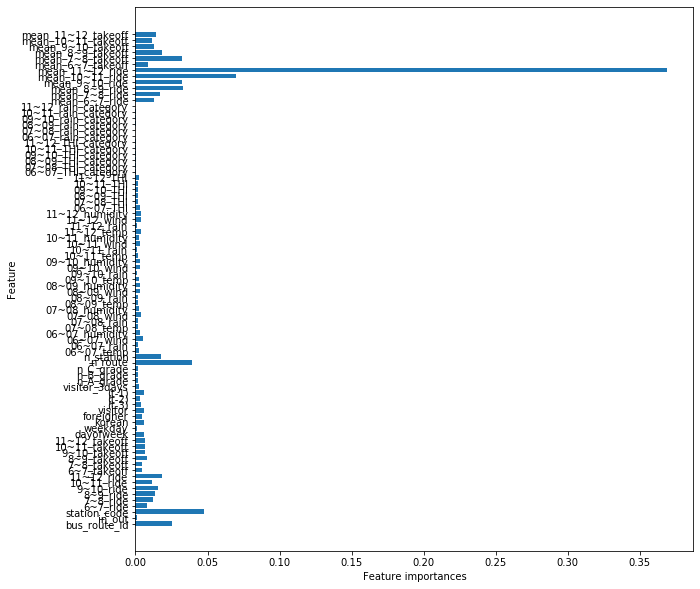

In [55]:
plot_feature_importances(rf, train.drop(["18~20_ride"], axis=1))

In [56]:
var_imp = []
for var, imp in zip(train.columns, rf.feature_importances_):
    var_imp.append((var, imp))
    
sorted(var_imp, key=lambda x: x[1], reverse=True)

[('mean_10~11_ride', 0.36876472878545963),
 ('mean_9~10_ride', 0.06996706763728945),
 ('station_code', 0.04737708149226997),
 ('n_C_grade', 0.03907470028648511),
 ('mean_7~8_ride', 0.032673703290123764),
 ('mean_8~9_ride', 0.03231204022396951),
 ('mean_6~7_takeoff', 0.03199811258764832),
 ('bus_route_id', 0.025124975272255604),
 ('mean_7~8_takeoff', 0.018206261743255642),
 ('11~12_ride', 0.01818934168201671),
 ('n_route', 0.01742946163878566),
 ('mean_6~7_ride', 0.01692285981866213),
 ('9~10_ride', 0.01572549351044764),
 ('mean_10~11_takeoff', 0.01409327758991394),
 ('8~9_ride', 0.013645483627485803),
 ('mean_8~9_takeoff', 0.013105951011441581),
 ('11~12_rain_category', 0.012864451452042555),
 ('7~8_ride', 0.012409556492274005),
 ('mean_9~10_takeoff', 0.011484774914903314),
 ('10~11_ride', 0.011366356029754185),
 ('mean_11~12_ride', 0.008813713189152052),
 ('8~9_takeoff', 0.00794797028237212),
 ('6~7_ride', 0.007919377460821983),
 ('11~12_takeoff', 0.006705428130605119),
 ('9~10_takeof

#### 모델 성능 확인

In [57]:
rf_train_score = rf.score(X_train, y_train)
rf_val_score   = rf.score(X_val, y_val)
rf_train_rmse  = np.sqrt(mean_squared_error(y_train, rf.predict(X_train))) 
rf_val_rmse    = np.sqrt(mean_squared_error(y_val,   rf.predict(X_val)))

print("Random Forest train R^2:  {:.2f}".format(rf_train_score))
print("Random Forest val   R^2:  {:.2f}".format(rf_val_score))
print("Random Forest train RMSE: {:.2f}".format(rf_train_rmse))
print("Random Forest val   RMSE: {:.2f}".format(rf_val_rmse))

Random Forest train R^2:  0.95
Random Forest val   R^2:  0.53
Random Forest train RMSE: 1.01
Random Forest val   RMSE: 3.21


### 03-02. XGBoost (eXtreme Gradient Boosting)

In [58]:
xgb = XGBRegressor(n_jobs=-1, random_state=42)
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

#### 모델 성능 확인

In [59]:
xgb_train_score = xgb.score(X_train, y_train)
xgb_val_score   = xgb.score(X_val,   y_val)
xgb_train_rmse  = np.sqrt(mean_squared_error(y_train, xgb.predict(X_train)))
xgb_val_rmse    = np.sqrt(mean_squared_error(y_val,   xgb.predict(X_val)))

print("XGBoost train R^2:  {:.2f}".format(xgb_train_score))
print("XGBoost val   R^2:  {:.2f}".format(xgb_val_score))
print("XGBoost train RMSE: {:.2f}".format(xgb_train_rmse))
print("XGBoost val   RMSE: {:.2f}".format(xgb_val_rmse))

XGBoost train R^2:  0.84
XGBoost val   R^2:  0.58
XGBoost train RMSE: 1.89
XGBoost val   RMSE: 3.03


### 03-03. LightGBM

In [60]:
lgbm = LGBMRegressor(n_jobs=-1, random_state=42)
lgbm.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### 모델 성능 확인

In [61]:
lgbm_train_score = lgbm.score(X_train, y_train)
lgbm_val_score   = lgbm.score(X_val,   y_val)
lgbm_train_rmse  = np.sqrt(mean_squared_error(y_train, lgbm.predict(X_train)))
lgbm_val_rmse    = np.sqrt(mean_squared_error(y_val,   lgbm.predict(X_val)))

print("LightGBM train R^2:  {:.2f}".format(lgbm_train_score))
print("LightGBM val   R^2:  {:.2f}".format(lgbm_val_score))
print("LightGBM train RMSE: {:.2f}".format(lgbm_train_rmse))
print("LightGBM val   RMSE: {:.2f}".format(lgbm_val_rmse))

LightGBM train R^2:  0.76
LightGBM val   R^2:  0.60
LightGBM train RMSE: 2.32
LightGBM val   RMSE: 2.98


### 평가
- RandomForest, XGBoost, LightGBM 모두 train셋과 val셋에서 성능 차이가 높은 것으로 보아 과대적합을 줄이기 위한 방법이 필요

# 04. 2차 모델링 - 변수 제거
- 현재 모델에 포함된 변수

In [62]:
train.columns

Index(['bus_route_id', 'in_out', 'station_code', '6~7_ride', '7~8_ride',
       '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff',
       '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff',
       '11~12_takeoff', '18~20_ride', 'dayofweek', 'weekday', 'korean',
       'foreigner', 'visitor', '(t-3)', '(t-2)', '(t-1)', 'visitor_3days',
       'n_A_grade', 'n_B_grade', 'n_C_grade', 'n_route', 'n_station',
       '06~07_temp', '06~07_rain', '06~07_wind', '06~07_humidity',
       '07~08_temp', '07~08_rain', '07~08_wind', '07~08_humidity',
       '08~09_temp', '08~09_rain', '08~09_wind', '08~09_humidity',
       '09~10_temp', '09~10_rain', '09~10_wind', '09~10_humidity',
       '10~11_temp', '10~11_rain', '10~11_wind', '10~11_humidity',
       '11~12_temp', '11~12_rain', '11~12_wind', '11~12_humidity', '06~07_THI',
       '07~08_THI', '08~09_THI', '09~10_THI', '10~11_THI', '11~12_THI',
       '06~07_THI_category', '07~08_THI_category', '08~09_THI_category',
     

- 1차 **`RandomForest`** 모델의 변수 중요도를 참고하여 날씨 관련 변수를 모델링에서 제외

In [63]:
var_2nd_drop = ['06~07_temp', '06~07_rain', '06~07_wind', '06~07_humidity', '07~08_temp', '07~08_rain', '07~08_wind', '07~08_humidity',
           '08~09_temp', '08~09_rain', '08~09_wind', '08~09_humidity', '09~10_temp', '09~10_rain', '09~10_wind', '09~10_humidity',
           '10~11_temp', '10~11_rain', '10~11_wind'', '10~11_rain_category', '11~12_rain_category', "18~20_ride"]
train_2nd = train.drop(var_2nd_drop, axis=1)
val_2nd = val.drop(var_2nd_drop, axis=1), '10~11_humidity', '11~12_temp', '11~12_rain', '11~12_wind', '11~12_humidity',
           '06~07_THI', '07~08_THI', '08~09_THI', '09~10_THI', '10~11_THI', '11~12_THI', '06~07_THI_category', '07~08_THI_category',
           '08~09_THI_category', '09~10_THI_category', '10~11_THI_category', '11~12_THI_category', '06~07_rain_category',
           '07~08_rain_category', '08~09_rain_category', '09~10_rain_category

X_train_2nd = train_2nd.values
X_val_2nd   = val_2nd.values

### 04-01. 랜덤 포레스트

In [64]:
rf_2nd = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_2nd.fit(X_train_2nd, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

#### 변수 중요도 확인

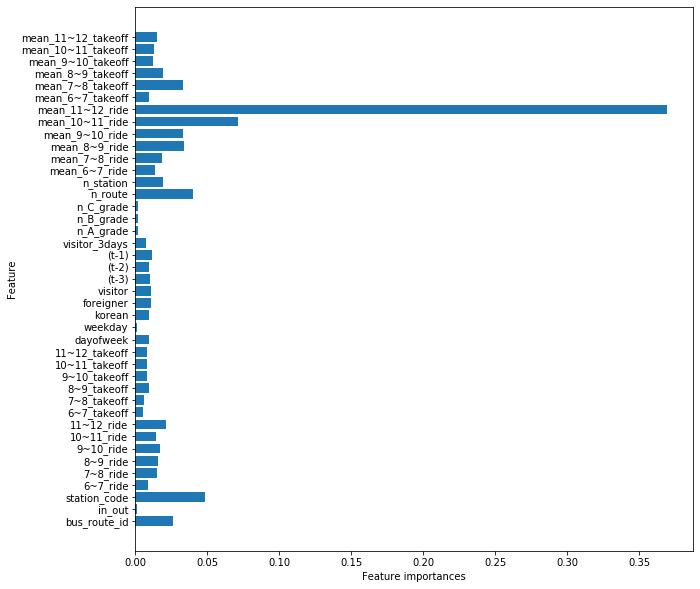

In [65]:
plot_feature_importances(rf_2nd, train_2nd)

In [66]:
var_imp_2nd = []
for var, imp in zip(train_2nd.columns, rf_2nd.feature_importances_):
    var_imp_2nd.append((var, imp))
    
sorted(var_imp_2nd, key=lambda x: x[1], reverse=True)

[('mean_11~12_ride', 0.3690718551848224),
 ('mean_10~11_ride', 0.0711566826688867),
 ('station_code', 0.048112894739058255),
 ('n_route', 0.040388346379133015),
 ('mean_8~9_ride', 0.034133479614033825),
 ('mean_7~8_takeoff', 0.03301702360395577),
 ('mean_9~10_ride', 0.03297924764005298),
 ('bus_route_id', 0.02645629711960647),
 ('11~12_ride', 0.02122565374850757),
 ('mean_8~9_takeoff', 0.019323599809778033),
 ('n_station', 0.019213309652037602),
 ('mean_7~8_ride', 0.018593746767739266),
 ('9~10_ride', 0.017200774670513244),
 ('8~9_ride', 0.016027932226228423),
 ('mean_11~12_takeoff', 0.01534465690419924),
 ('7~8_ride', 0.015013117906167325),
 ('10~11_ride', 0.014157336347084507),
 ('mean_6~7_ride', 0.013384218763254751),
 ('mean_10~11_takeoff', 0.012705474676155704),
 ('mean_9~10_takeoff', 0.012539262457430339),
 ('(t-1)', 0.011557193284209795),
 ('visitor', 0.011080743031797012),
 ('foreigner', 0.01077456357893855),
 ('(t-3)', 0.010376367294949762),
 ('korean', 0.009794185549793635),


#### 모델 성능 확인

In [67]:
rf_2nd_train_score = rf_2nd.score(X_train_2nd, y_train)
rf_2nd_val_score   = rf_2nd.score(X_val_2nd, y_val)
rf_2nd_train_rmse  = np.sqrt(mean_squared_error(y_train, rf_2nd.predict(X_train_2nd))) 
rf_2nd_val_rmse    = np.sqrt(mean_squared_error(y_val,   rf_2nd.predict(X_val_2nd)))

print("Random Forest 2nd train R^2:  {:.2f}".format(rf_2nd_train_score))
print("Random Forest 2nd val   R^2:  {:.2f}".format(rf_2nd_val_score))
print("Random Forest 2nd train RMSE: {:.2f}".format(rf_2nd_train_rmse))
print("Random Forest 2nd val   RMSE: {:.2f}".format(rf_2nd_val_rmse))

Random Forest 2nd train R^2:  0.96
Random Forest 2nd val   R^2:  0.54
Random Forest 2nd train RMSE: 0.99
Random Forest 2nd val   RMSE: 3.16


### 04-02. XGBoost (eXtreme Gradient Boosting)

In [68]:
xgb_2nd = XGBRegressor(n_jobs=-1, random_state=42)
xgb_2nd.fit(X_train_2nd, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

#### 모델 성능 확인

In [69]:
xgb_2nd_train_score = xgb_2nd.score(X_train_2nd, y_train)
xgb_2nd_val_score   = xgb_2nd.score(X_val_2nd, y_val)
xgb_2nd_train_rmse  = np.sqrt(mean_squared_error(y_train, xgb_2nd.predict(X_train_2nd))) 
xgb_2nd_val_rmse    = np.sqrt(mean_squared_error(y_val,   xgb_2nd.predict(X_val_2nd)))

print("XGBoost 2nd train R^2:  {:.2f}".format(xgb_2nd_train_score))
print("XGBoost 2nd val   R^2:  {:.2f}".format(xgb_2nd_val_score))
print("XGBoost 2nd train RMSE: {:.2f}".format(xgb_2nd_train_rmse))
print("XGBoost 2nd val   RMSE: {:.2f}".format(xgb_2nd_val_rmse))

XGBoost 2nd train R^2:  0.84
XGBoost 2nd val   R^2:  0.58
XGBoost 2nd train RMSE: 1.92
XGBoost 2nd val   RMSE: 3.05


### 04-03. LightGBM

In [70]:
lgbm_2nd = LGBMRegressor(n_jobs=-1, random_state=42)
lgbm_2nd.fit(X_train_2nd, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### 모델 성능 확인

In [71]:
lgbm_2nd_train_score = lgbm_2nd.score(X_train_2nd, y_train)
lgbm_2nd_val_score   = lgbm_2nd.score(X_val_2nd, y_val)
lgbm_2nd_train_rmse  = np.sqrt(mean_squared_error(y_train, lgbm_2nd.predict(X_train_2nd))) 
lgbm_2nd_val_rmse    = np.sqrt(mean_squared_error(y_val,   lgbm_2nd.predict(X_val_2nd)))

print("LightGBM 2nd train R^2:  {:.2f}".format(lgbm_2nd_train_score))
print("LightGBM 2nd val   R^2:  {:.2f}".format(lgbm_2nd_val_score))
print("LightGBM 2nd train RMSE: {:.2f}".format(lgbm_2nd_train_rmse))
print("LightGBM 2nd val   RMSE: {:.2f}".format(lgbm_2nd_val_rmse))

LightGBM 2nd train R^2:  0.76
LightGBM 2nd val   R^2:  0.59
LightGBM 2nd train RMSE: 2.34
LightGBM 2nd val   RMSE: 3.02


#### 평가
- 2차 모델링의 결과에서도 과대적합이 발생
- 비슷한 정보를 가지고 있는 변수 제거하여 3차 모델링 진행

# 05. 3차 모델링 - 변수 제거
- 현재 모델에 포함된 변수

In [72]:
train_2nd.columns

Index(['bus_route_id', 'in_out', 'station_code', '6~7_ride', '7~8_ride',
       '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff',
       '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff',
       '11~12_takeoff', 'dayofweek', 'weekday', 'korean', 'foreigner',
       'visitor', '(t-3)', '(t-2)', '(t-1)', 'visitor_3days', 'n_A_grade',
       'n_B_grade', 'n_C_grade', 'n_route', 'n_station', 'mean_6~7_ride',
       'mean_7~8_ride', 'mean_8~9_ride', 'mean_9~10_ride', 'mean_10~11_ride',
       'mean_11~12_ride', 'mean_6~7_takeoff', 'mean_7~8_takeoff',
       'mean_8~9_takeoff', 'mean_9~10_takeoff', 'mean_10~11_takeoff',
       'mean_11~12_takeoff'],
      dtype='object')

- 2차 **`RandomForest`** 모델의 변수 중요도를 참고하여 비슷한 의미를 가지는 변수 및 중요도가 낮은 변수를 모델링에서 제외

In [73]:
var_3rd_drop = ["in_out", 'weekday', "n_A_grade", "n_B_grade", "n_C_grade"]

train_3rd = train_2nd.drop(var_3rd_drop, axis=1)
val_3rd = val_2nd.drop(var_3rd_drop, axis=1)

X_train_3rd = train_3rd.values
X_val_3rd   = val_3rd.values

### 05-01. 랜덤 포레스트

In [74]:
rf_3rd = RandomForestRegressor(n_jobs=-1, random_state=42)
rf_3rd.fit(X_train_3rd, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

#### 변수 중요도 확인

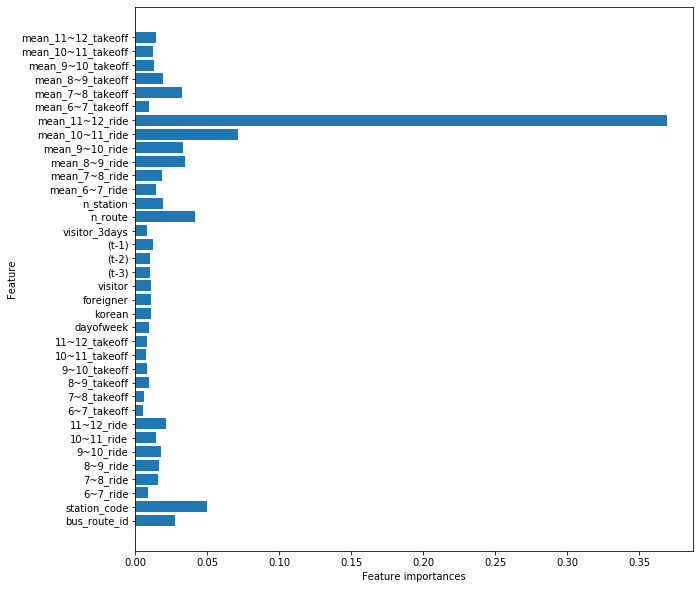

In [75]:
plot_feature_importances(rf_3rd, train_3rd)

In [76]:
var_imp_3rd = []
for var, imp in zip(train_3rd.columns, rf_3rd.feature_importances_):
    var_imp_3rd.append((var, imp))
    
sorted(var_imp_3rd, key=lambda x: x[1], reverse=True)

[('mean_11~12_ride', 0.3691466638433527),
 ('mean_10~11_ride', 0.07124447061167745),
 ('station_code', 0.049526219814196776),
 ('n_route', 0.04169458928599),
 ('mean_8~9_ride', 0.03424755579791548),
 ('mean_9~10_ride', 0.03335267957558742),
 ('mean_7~8_takeoff', 0.032728256269614765),
 ('bus_route_id', 0.027329286393728495),
 ('11~12_ride', 0.021072609675866254),
 ('n_station', 0.019371501394223507),
 ('mean_8~9_takeoff', 0.019227786273803244),
 ('mean_7~8_ride', 0.0188245839617552),
 ('9~10_ride', 0.01761289886465898),
 ('8~9_ride', 0.01636346337351161),
 ('7~8_ride', 0.015598314661313216),
 ('mean_11~12_takeoff', 0.014526439451304433),
 ('10~11_ride', 0.01444689869525449),
 ('mean_6~7_ride', 0.014141203963570473),
 ('mean_9~10_takeoff', 0.013278867299622151),
 ('mean_10~11_takeoff', 0.012592625390536969),
 ('(t-1)', 0.011968807032130269),
 ('visitor', 0.01093622194557971),
 ('foreigner', 0.01077771962744056),
 ('korean', 0.010622375078909698),
 ('(t-2)', 0.009974128604968047),
 ('(t-

#### 모델 성능 확인

In [77]:
rf_3rd_train_score = rf_3rd.score(X_train_3rd, y_train)
rf_3rd_val_score   = rf_3rd.score(X_val_3rd, y_val)
rf_3rd_train_rmse  = np.sqrt(mean_squared_error(y_train, rf_3rd.predict(X_train_3rd))) 
rf_3rd_val_rmse    = np.sqrt(mean_squared_error(y_val,   rf_3rd.predict(X_val_3rd)))

print("Random Forest 3rd train R^2:  {:.2f}".format(rf_3rd_train_score))
print("Random Forest 3rd val   R^2:  {:.2f}".format(rf_3rd_val_score))
print("Random Forest 3rd train RMSE: {:.2f}".format(rf_3rd_train_rmse))
print("Random Forest 3rd val   RMSE: {:.2f}".format(rf_3rd_val_rmse))

Random Forest 3rd train R^2:  0.96
Random Forest 3rd val   R^2:  0.54
Random Forest 3rd train RMSE: 0.99
Random Forest 3rd val   RMSE: 3.16


### 05-02. XGBoost (eXtreme Gradient Boosting)

In [78]:
xgb_3rd = XGBRegressor(n_jobs=-1, random_state=42)
xgb_3rd.fit(X_train_3rd, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

#### 모델 성능 확인

In [79]:
xgb_3rd_train_score = xgb_3rd.score(X_train_3rd, y_train)
xgb_3rd_val_score   = xgb_3rd.score(X_val_3rd, y_val)
xgb_3rd_train_rmse  = np.sqrt(mean_squared_error(y_train, xgb_3rd.predict(X_train_3rd))) 
xgb_3rd_val_rmse    = np.sqrt(mean_squared_error(y_val,   xgb_3rd.predict(X_val_3rd)))

print("XGBoost 3rd train R^2:  {:.2f}".format(xgb_3rd_train_score))
print("XGBoost 3rd val   R^2:  {:.2f}".format(xgb_3rd_val_score))
print("XGBoost 3rd train RMSE: {:.2f}".format(xgb_3rd_train_rmse))
print("XGBoost 3rd val   RMSE: {:.2f}".format(xgb_3rd_val_rmse))

XGBoost 3rd train R^2:  0.84
XGBoost 3rd val   R^2:  0.59
XGBoost 3rd train RMSE: 1.90
XGBoost 3rd val   RMSE: 3.00


### 05-03. LightGBM

In [80]:
lgbm_3rd = LGBMRegressor(n_jobs=-1, random_state=42)
lgbm_3rd.fit(X_train_3rd, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### 모델 성능 확인

In [81]:
lgbm_3rd_train_score = lgbm_3rd.score(X_train_3rd, y_train)
lgbm_3rd_val_score   = lgbm_3rd.score(X_val_3rd, y_val)
lgbm_3rd_train_rmse  = np.sqrt(mean_squared_error(y_train, lgbm_3rd.predict(X_train_3rd))) 
lgbm_3rd_val_rmse    = np.sqrt(mean_squared_error(y_val,   lgbm_3rd.predict(X_val_3rd)))

print("LightGBM 3rd train R^2:  {:.2f}".format(lgbm_3rd_train_score))
print("LightGBM 3rd val   R^2:  {:.2f}".format(lgbm_3rd_val_score))
print("LightGBM 3rd train RMSE: {:.2f}".format(lgbm_3rd_train_rmse))
print("LightGBM 3rd val   RMSE: {:.2f}".format(lgbm_3rd_val_rmse))

LightGBM 3rd train R^2:  0.76
LightGBM 3rd val   R^2:  0.59
LightGBM 3rd train RMSE: 2.34
LightGBM 3rd val   RMSE: 3.01


### 05-04. 중간 평가 - 1차, 2차, 3차 모델링의 결과를 종합적으로 평가
- 모델을 구성하는 변수의 숫자는 줄어들었지만 성능은 개선되지 않고 지속적인 과대적합 발생

In [82]:
print("-----------------RandomForest---------------")
print("1st train RMSE: {:.2f} \t1st train R^2: {:.2f}".format(rf_train_rmse, rf_train_score))
print("1st val   RMSE: {:.2f} \t1st val   R^2: {:.2f}".format(rf_val_rmse,   rf_val_score))
print("--------------------------------------------")
print("2nd train RMSE: {:.2f} \t2nd train R^2: {:.2f}".format(rf_2nd_train_rmse, rf_2nd_train_score))
print("2nd val   RMSE: {:.2f} \t2nd val   R^2: {:.2f}".format(rf_2nd_val_rmse,   rf_2nd_val_score))
print("--------------------------------------------")
print("3rd train RMSE: {:.2f} \t3rd train R^2: {:.2f}".format(rf_3rd_train_rmse, rf_3rd_train_score))
print("3rd val   RMSE: {:.2f} \t3rd val   R^2: {:.2f}".format(rf_3rd_val_rmse,   rf_3rd_val_score))

-----------------RandomForest---------------
1st train RMSE: 1.01 	1st train R^2: 0.95
1st val   RMSE: 3.21 	1st val   R^2: 0.53
--------------------------------------------
2nd train RMSE: 0.99 	2nd train R^2: 0.96
2nd val   RMSE: 3.16 	2nd val   R^2: 0.54
--------------------------------------------
3rd train RMSE: 0.99 	3rd train R^2: 0.96
3rd val   RMSE: 3.16 	3rd val   R^2: 0.54


In [83]:
print("--------------------XGBoost-----------------")
print("1st train RMSE: {:.2f} \t1st train R^2: {:.2f}".format(xgb_train_rmse, xgb_train_score))
print("1st val   RMSE: {:.2f} \t1st val   R^2: {:.2f}".format(xgb_val_rmse,   xgb_val_score))
print("--------------------------------------------")
print("2nd train RMSE: {:.2f} \t2nd train R^2: {:.2f}".format(xgb_2nd_train_rmse, xgb_2nd_train_score))
print("2nd val   RMSE: {:.2f} \t2nd val   R^2: {:.2f}".format(xgb_2nd_val_rmse,   xgb_2nd_val_score))
print("--------------------------------------------")
print("3rd train RMSE: {:.2f} \t3rd train R^2: {:.2f}".format(xgb_3rd_train_rmse, xgb_3rd_train_score))
print("3rd val   RMSE: {:.2f} \t3rd val   R^2: {:.2f}".format(xgb_3rd_val_rmse,   xgb_3rd_val_score))

--------------------XGBoost-----------------
1st train RMSE: 1.89 	1st train R^2: 0.84
1st val   RMSE: 3.03 	1st val   R^2: 0.58
--------------------------------------------
2nd train RMSE: 1.92 	2nd train R^2: 0.84
2nd val   RMSE: 3.05 	2nd val   R^2: 0.58
--------------------------------------------
3rd train RMSE: 1.90 	3rd train R^2: 0.84
3rd val   RMSE: 3.00 	3rd val   R^2: 0.59


In [84]:
print("-------------------LightGBM-----------------")
print("1st train RMSE: {:.2f} \t1st train R^2: {:.2f}".format(lgbm_train_rmse, lgbm_train_score))
print("1st val   RMSE: {:.2f} \t1st val   R^2: {:.2f}".format(lgbm_val_rmse,   lgbm_val_score))
print("--------------------------------------------")
print("2nd train RMSE: {:.2f} \t2nd train R^2: {:.2f}".format(lgbm_2nd_train_rmse, lgbm_2nd_train_score))
print("2nd val   RMSE: {:.2f} \t2nd val   R^2: {:.2f}".format(lgbm_2nd_val_rmse,   lgbm_2nd_val_score))
print("--------------------------------------------")
print("3rd train RMSE: {:.2f} \t3rd train R^2: {:.2f}".format(lgbm_3rd_train_rmse, lgbm_3rd_train_score))
print("3rd val   RMSE: {:.2f} \t3rd val   R^2: {:.2f}".format(lgbm_3rd_val_rmse,   lgbm_3rd_val_score))

-------------------LightGBM-----------------
1st train RMSE: 2.32 	1st train R^2: 0.76
1st val   RMSE: 2.98 	1st val   R^2: 0.60
--------------------------------------------
2nd train RMSE: 2.34 	2nd train R^2: 0.76
2nd val   RMSE: 3.02 	2nd val   R^2: 0.59
--------------------------------------------
3rd train RMSE: 2.34 	3rd train R^2: 0.76
3rd val   RMSE: 3.01 	3rd val   R^2: 0.59


# 06. 파라미터 튜닝
- 1차, 2차, 3차 모델링에서 가장 성능이 좋았던 **`LightGBM`** 모델의 최적 매개변수를 그리드 서치를 통해 설정

### 06-01. LightGBM Parameter tunning

In [123]:
best_score = 0
for max_depth in [3, 5, 7]:
    for n_estimators in [100, 200, 300]:
        for learning_rate in [0.001, 0.01, 0.1, 1, 10, 100]:
            lgbm = LGBMRegressor(max_depth=max_depth,
                               n_estimators=n_estimators, 
                               learning_rate=learning_rate,
                               n_jobs=-1,
                               random_state=42)
            
            # 교차 검증을 적용합니다.
            scores = cross_val_score(lgbm, X_train, y_train, cv=5)

            # 교차 검증 정확도의 평균을 계산합니다.
            score = np.mean(scores)

            # 점수가 더 높으면 매개변수와 함께 기록합니다.
            if score > best_score:
                best_score = score
                best_parameters = {"max_depth":max_depth, "n_estimators":n_estimators, "learning_rate":learning_rate}

grid_lgbm_1st = LGBMRegressor(**best_parameters, n_jobs=-1, random_state=42)

In [124]:
best_score = 0
for max_depth in [3, 5, 7]:
    for n_estimators in [100, 200, 300]:
        for learning_rate in [0.001, 0.01, 0.1, 1, 10, 100]:
            lgbm = LGBMRegressor(max_depth=max_depth,
                               n_estimators=n_estimators, 
                               learning_rate=learning_rate,
                               n_jobs=-1,
                               random_state=42)
            
            # 교차 검증을 적용합니다.
            scores = cross_val_score(lgbm, X_train_2nd, y_train, cv=5)

            # 교차 검증 정확도의 평균을 계산합니다.
            score = np.mean(scores)

            # 점수가 더 높으면 매개변수와 함께 기록합니다.
            if score > best_score:
                best_score = score
                best_parameters = {"max_depth":max_depth, "n_estimators":n_estimators, "learning_rate":learning_rate}

grid_lgbm_2nd = LGBMRegressor(**best_parameters, n_jobs=-1, random_state=42)

In [125]:
best_score = 0
for max_depth in [3, 5, 7]:
    for n_estimators in [100, 200, 300]:
        for learning_rate in [0.001, 0.01, 0.1, 1, 10, 100]:
            lgbm = LGBMRegressor(max_depth=max_depth,
                               n_estimators=n_estimators, 
                               learning_rate=learning_rate,
                               n_jobs=-1,
                               random_state=42)
            
            # 교차 검증을 적용합니다.
            scores = cross_val_score(lgbm, X_train_3rd, y_train, cv=5)

            # 교차 검증 정확도의 평균을 계산합니다.
            score = np.mean(scores)

            # 점수가 더 높으면 매개변수와 함께 기록합니다.
            if score > best_score:
                best_score = score
                best_parameters = {"max_depth":max_depth, "n_estimators":n_estimators, "learning_rate":learning_rate}

grid_lgbm_3rd = LGBMRegressor(**best_parameters, n_jobs=-1, random_state=42)

#### 최적의 매개변수로 모델 피팅

In [126]:
grid_lgbm_1st.fit(X_train, y_train)
grid_lgbm_2nd.fit(X_train_2nd, y_train)
grid_lgbm_3rd.fit(X_train_3rd, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=300, n_jobs=-1, num_leaves=31, objective=None,
              random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

#### 모델 성능 확인

In [128]:
grid_lgbm_1st_train_score = grid_lgbm_1st.score(X_train, y_train)
grid_lgbm_1st_val_score   = grid_lgbm_1st.score(X_val, y_val)
grid_lgbm_1st_train_rmse  = np.sqrt(mean_squared_error(y_train, grid_lgbm_1st.predict(X_train))) 
grid_lgbm_1st_val_rmse    = np.sqrt(mean_squared_error(y_val,   grid_lgbm_1st.predict(X_val)))

grid_lgbm_2nd_train_score = grid_lgbm_2nd.score(X_train_2nd, y_train)
grid_lgbm_2nd_val_score   = grid_lgbm_2nd.score(X_val_2nd, y_val)
grid_lgbm_2nd_train_rmse  = np.sqrt(mean_squared_error(y_train, grid_lgbm_2nd.predict(X_train_2nd))) 
grid_lgbm_2nd_val_rmse    = np.sqrt(mean_squared_error(y_val,   grid_lgbm_2nd.predict(X_val_2nd)))

grid_lgbm_3rd_train_score = grid_lgbm_3rd.score(X_train_3rd, y_train)
grid_lgbm_3rd_val_score   = grid_lgbm_3rd.score(X_val_3rd, y_val)
grid_lgbm_3rd_train_rmse  = np.sqrt(mean_squared_error(y_train, grid_lgbm_3rd.predict(X_train_3rd))) 
grid_lgbm_3rd_val_rmse    = np.sqrt(mean_squared_error(y_val,   grid_lgbm_3rd.predict(X_val_3rd)))

In [129]:
print("---------------LightGBMGridSearch------------")
print("1st train RMSE: {:.2f} \t1st train R^2: {:.2f}".format(grid_lgbm_1st_train_rmse, grid_lgbm_1st_train_score))
print("1st val   RMSE: {:.2f} \t1st val   R^2: {:.2f}".format(grid_lgbm_1st_val_rmse,   grid_lgbm_1st_val_score))
print("--------------------------------------------")
print("2nd train RMSE: {:.2f} \t2nd train R^2: {:.2f}".format(grid_lgbm_2nd_train_rmse, grid_lgbm_2nd_train_score))
print("2nd val   RMSE: {:.2f} \t2nd val   R^2: {:.2f}".format(grid_lgbm_2nd_val_rmse,   grid_lgbm_2nd_val_score))
print("--------------------------------------------")
print("3rd train RMSE: {:.2f} \t3rd train R^2: {:.2f}".format(grid_lgbm_3rd_train_rmse, grid_lgbm_3rd_train_score))
print("3rd val   RMSE: {:.2f} \t3rd val   R^2: {:.2f}".format(grid_lgbm_3rd_val_rmse,   grid_lgbm_3rd_val_score))

---------------LightGBMGridSearch------------
1st train RMSE: 2.05 	1st train R^2: 0.81
1st val   RMSE: 2.93 	1st val   R^2: 0.61
--------------------------------------------
2nd train RMSE: 2.07 	2nd train R^2: 0.81
2nd val   RMSE: 2.95 	2nd val   R^2: 0.60
--------------------------------------------
3rd train RMSE: 2.07 	3rd train R^2: 0.81
3rd val   RMSE: 2.93 	3rd val   R^2: 0.61


## 최종 모델링
- **`validation`** 셋에 대해서는 성능이 가장 좋으면서 변수를 가장 적게 사용하는 **`grid_lgbm_3rd_val`**를 최종 모델로 선정

#### `trainval` 셋으로 최종 모델 피팅

In [140]:
X_trainval = trainval[train_3rd.columns].values
y_trainval = trainval["18~20_ride"].values

In [141]:
model = grid_lgbm_3rd.fit(X_trainval, y_trainval)

In [139]:
X_trainval

,bus_route_id,station_code,6~7_ride,7~8_ride,8~9_ride,9~10_ride,10~11_ride,11~12_ride,6~7_takeoff,7~8_takeoff,...,mean_8~9_ride,mean_9~10_ride,mean_10~11_ride,mean_11~12_ride,mean_6~7_takeoff,mean_7~8_takeoff,mean_8~9_takeoff,mean_9~10_takeoff,mean_10~11_takeoff,mean_11~12_takeoff
0,4270000,344,0.0,1.0,2.0,5.0,2.0,6.0,0.0,0.0,...,2.6,2.0,2.0,2.0,0.00,0.0,0.0,0.2,0.0,0.0
1,4270000,357,1.0,4.0,4.0,2.0,5.0,6.0,0.0,0.0,...,6.2,3.0,6.2,4.2,0.00,0.0,0.0,0.0,0.0,0.0
2,4270000,432,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.6,0.00,0.0,0.0,0.0,0.0,0.0
3,4270000,1579,0.0,17.0,6.0,26.0,14.0,16.0,0.0,0.0,...,11.4,17.2,13.8,19.2,0.00,0.0,0.0,0.0,0.0,0.0
4,4270000,1646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.6,0.0,0.00,0.0,0.2,0.8,0.2,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,32820000,1129,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0
415419,32820000,1564,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
415420,32820000,2322,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.00,1.0,0.0,0.0,0.0,0.0
415421,32820000,3291,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0


#### test 데이터 변환

In [143]:
test["weekday"] = test.date.apply(weekday_category)

In [145]:
test_passengers = test.drop(["id", "date", "station_name", "latitude", "longitude", 'weekday'], axis=1)
test_passengers["bus"] = test_passengers.bus_route_id.astype(str) + " " + test_passengers.in_out.astype(str) + " " + test_passengers.station_code.astype(str) + " " + test_passengers.dayofweek.astype(str)
test_passengers.drop(["bus_route_id", "in_out", "station_code", "dayofweek"], axis=1, inplace=True)
test_passengers = test_passengers.groupby("bus").mean().reset_index()
 
col_list = []
    
for col_idx in range(1, len(test_passengers.columns)):
    col_list.append("mean_" + test_passengers.columns[col_idx])
        
col_list = ["bus"] + col_list
test_passengers.columns = col_list
    
test_passengers["bus_route_id"] = test_passengers.bus.apply(lambda x: x.split(" ")[0]).astype(int)
test_passengers["in_out"] =  test_passengers.bus.apply(lambda x: x.split(" ")[1])
test_passengers["station_code"] =  test_passengers.bus.apply(lambda x: x.split(" ")[2]).astype(int)
test_passengers["dayofweek"] = test_passengers.bus.apply(lambda x: x.split(" ")[3]).astype(int)
test_passengers.drop(["bus"], axis=1, inplace=True)

In [146]:
test = test.merge(airport,  how="left")
test = test.merge(stn,      how="left")
test = test.merge(route,    how="left")
test = test.merge(weather2, how="left")
test = test.merge(test_passengers, how="left")

In [148]:
test = test.drop(["id", "date", "station_name", "latitude", "longitude", "weather_stn_id", "weather_stn_name", 
                    "weather_stn_latitude", "weather_stn_longitude"], axis=1)

In [149]:
test.loc[test.in_out=="시내", "in_out"] = 0
test.loc[test.in_out=="시외", "in_out"] = 1

for category_var in ["bus_route_id", "in_out", "station_code", "dayofweek", "weekday"]:
    test[category_var] = pd.Categorical(test[category_var])

In [152]:
X_test = test[train_3rd.columns].values

In [154]:
result = pd.read_csv("./data/submission_sample.csv")

In [153]:
y_test = model.predict(X_test)

In [165]:
result["18~20_ride"] = y_test

In [164]:
result.to_csv("./data/result.csv", index=False)